# PHYS 598 - Space Physics

## Dr. Emma Spanswick

#### Filobateer Ghaly - 10175960

____

## Anomalies in Prototype Riometer Instrument

### An investigation using HF and VHF ionospheric propagation to describe a sharp absorption peak in both terrestial and sky signals.
___

## Introduction

High Frequency (HF) radio waves (between 3 and 30 MHz) are used in a type of communication typically called shortwave radio to transfer signals beyond the line of sight. This range of frequencies leverages properties of the ionosphere, the ionized layer of the upper atmosphere, to 'skip' or bounce between the Earth and the ionosphere to propagate. Frequencies higher than 30 MHz (VHF and above) tend to go through the ionosphere without enough refraction to bend backwards towards the Earth. This is because the plasma in the ionosphere usually has a lower frequency than VHF waves and the dielectric constant of this plasma is effectively 1, meaning these waves pass through without any noticeable refraction. Though this is neglecting magnetic effects of Earth's field such as Faraday Rotation where these waves are polarized as they pass through the medium and ignoring the presence of electron collisions, it is a rather accurate approximation of what happens on the surface level assuming ideal situations. As such, the ionosphere is a complex and dynamic system, which, depending on its state and the frequency of the radio wave, allows for what is referred to as skywave propagation- or the bouncing of radio waves off the ionosphere. The complexity of this system is not limited to the above-mentioned effects. The sun from which energetic particles are constantly being ejected and Earth's magnetic field, which shields us from these particles, are highly dynamic systems themselves which have direct effects on the ionosphere. This highlights the multi-dimensionality of the ionosphere as a system that allows for HF propagation and directly impacts it. The purpose of this study is to investigate data from a recently deployed Riometer, a prototype instrument that measures the signal strength of radio waves ranging from 1 to 50 MHz. The enhanced capability of measuring signals at 1 to 20 MHz means the HF band is included in this data. There were some radio blackouts at ~8 MHz and below which coincided with a high absorption peak in frequencies above 20 MHz. This project aims to find connections between the HF and VHF bands, which could potentially expose an underlying connection between ionospheric disturbances and ground-wave propagation.

___

## Method of Investigation - I

### Spectral Analysis

For the first part of this investigation, we dissect the event on the **24th of November, 2019** where we observe the sharp absorption peak in the spectral plot. The frequencies known to be transmitted from **Alert, Bunavut** are  $ 5.382, 6.9285, 8.0995, 10.422, 11.107, $ and  $ 14.3704 \  \mathrm{MHz} $. Part of the dissection of the spectral plot is to quantify the power drop for these frequencies. 

To begin this process, we first reconstruct the spectral plot from data that has been averaged (binned) using an FFT algorithm. The following function definitions allow us to dissect any part of the plot, whether it is a single frequency or a range of frequencies. They also allow us to investigate a time range *(a certain period in the day for a range of frequencies or a single frequency)*. 

##### Single frequencies are actually bins with specific bandwidths as will be discussed and tabulated later for the Alert frequencies.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

def Read_4_Column_File(file_name):
    data  = open(file_name, 'r'); lines = data.readlines();
    
    #Remove first line
    lines.pop(0)
    mint = []; sec = []; freq = []; power = [];

    for line in lines:
        p = line.split()
        mint.append(float(p[0])); sec.append(float(p[1])); freq.append(float(p[2])); power.append(float(p[3]))
        
    data.close()
    return mint, sec, freq, power

# A func to pull into lists and add to array
def pull_append(file_string, i):
    list_mint, list_sec, list_freq, list_power = np.asarray(Read_4_Column_File(file_string))
    #print(len(list_mint))
    Mint[i] = list_mint/60 + i + list_sec/3600
    #Sec[i] = list_sec
    Freq[i] = list_freq
    Power[i] = list_power
    

Mint = [[0]*24]*24; Sec = [[0]*24]*24; Freq = [[0]*24]*24; Power = [[0]*24]*24;

def Gimme_Gimme(num):
    for i in range(0, num):
        if i <  10:
            file_string = '20191121_' + '0' + str(i) + '00' + '_gill_iris-04_sddr1' + 'a' +'_1hz_v2.txt'
            pull_append(file_string, i)
            
        if i >= 10:
            file_string = '20191121_'  + str(i) + '00' + '_gill_iris-04_sddr1' + 'a' +'_1hz_v2.txt'
            pull_append(file_string, i)

    return Mint, Sec, Freq, Power

In [2]:
Mint, Sec, Freq, Power = Gimme_Gimme(24)

In [3]:
factor = 2024/50
print("There are 50 frequencies. 2024/50 = ", factor, " is the factor I would multiply a frequency by to get the index.")
print("To get 42.5 MHz for example, its index would be ", factor*42.5, "or ", int(factor*42.5))

There are 50 frequencies. 2024/50 =  40.48  is the factor I would multiply a frequency by to get the index.
To get 42.5 MHz for example, its index would be  1720.3999999999999 or  1720


In [4]:
def split(time_list, freq_list, pow_list, file_num, index, r_type ):
    new_list_time = [time_list[file_num][i:i+360] for i in range(0, 2024*360, 360)]
    new_list_freq = [freq_list[file_num][i:i+360] for i in range(0, 2024*360, 360)]
    new_list_power = [pow_list[file_num][i:i+360] for i in range(0, 2024*360, 360)]
    
    if r_type == 't': return new_list_time[index]
    if r_type == 'f': return new_list_freq[index]
    if r_type == 'p': return new_list_power[index]

def get_bins(Mint, Freq, Power, freq_index):
    freq_bin = []
    time_bin = []
    pow_bin = []
    for i in range(24):
        freq_bin.append(split(Mint, Freq, Power, i, freq_index, r_type = 'f'))
        time_bin.append(split(Mint, Freq, Power, i,  freq_index, r_type = 't'))
        pow_bin.append(split(Mint, Freq, Power, i,  freq_index, r_type = 'p'))
    
    flat_bin_freq = np.ravel(freq_bin)
    flat_bin_time = np.ravel(time_bin)
    flat_bin_pow = np.ravel(pow_bin)
    
    return flat_bin_time, flat_bin_freq, flat_bin_pow

b_time, b_freq, b_pow = get_bins(Mint, Freq, Power, 1720)


In [6]:
def range_giver(Mint, Freq, Power, r_min, r_max):
    
    freq_bin = []
    time_bin = []
    pow_bin = []
    for i in range(r_min, r_max, 1):
        t, f, p = get_bins(Mint, Freq, Power, i)
        time_bin.append(t)
        freq_bin.append(f)
        pow_bin.append(p)
    
    time = np.ravel(time_bin)
    freq = np.ravel(freq_bin)
    power = np.ravel(pow_bin)
    
    return time, freq, power 

x, y, z = range_giver(Mint, Freq, Power, 0, 2024)

In [7]:
print(len(x), 2024*360*24, "This implies that there was no down-sampling of the data.")

17487360 17487360 This implies that there was no down-sampling of the data.


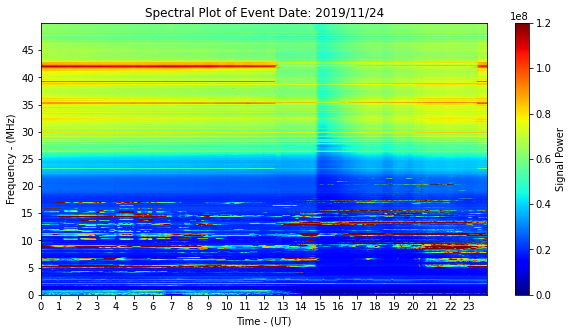

In [8]:
colourMap = plt.cm.jet

plt.figure(figsize=(10,5))
plt.scatter(x,y,c=z,
                vmin=0, vmax=1.2e8,cmap=colourMap)

plt.xlim(0,24)
plt.ylim(0, 50)
plt.xticks(np.arange(0, 24, 1))
plt.yticks(np.arange(0, 50, 5))
plt.xlabel('Time - (UT)')
plt.ylabel('Frequency - (MHz)')
plt.title('Spectral Plot of Event Date: 2019/11/24')


cbar = plt.colorbar()
cbar.set_label('Signal Power')

plt.show()

Notice the sharp peak at about 15 UT.

___

We can now begin isolate each frequency according to the bin closest to representing it.

In [9]:
print("To get 5.382 MHz for example, its index would be ", factor*5.382, "or ", int(factor*5.382))
print("To get 6.9285 MHz for example, its index would be ", factor*6.9285, "or ", int(factor*6.9285))
print("To get 8.0995 MHz for example, its index would be ", factor*8.0995, "or ", int(factor*8.0995))
print("To get 10.422 MHz for example, its index would be ", factor*10.422, "or ", int(factor*10.422))
print("To get 11.107 MHz for example, its index would be ", factor*11.107, "or ", int(factor*11.107))
print("To get 14.3704 MHz for example, its index would be ", factor* 14.3704, "or ", int(factor* 14.3704))

To get 5.382 MHz for example, its index would be  217.86335999999997 or  217
To get 6.9285 MHz for example, its index would be  280.46567999999996 or  280
To get 8.0995 MHz for example, its index would be  327.86776000000003 or  327
To get 10.422 MHz for example, its index would be  421.88256 or  421
To get 11.107 MHz for example, its index would be  449.61135999999993 or  449
To get 14.3704 MHz for example, its index would be  581.713792 or  581


In [10]:
# To check
b_num = 217
os = 3
def checker(b_num, os, o_freq):
    ind = b_num + os
    t_bin, f_bin, p_bin = get_bins(Mint, Freq, Power, ind)
    print("Target Frequency = ", o_freq)
    print("The frequency bin is: ", f_bin)
    
    p_diff = (f_bin[0] - o_freq)*100/o_freq
    print("The percent diff = ", p_diff)
    print('\n')
    return t_bin, f_bin, p_bin

f1_t, f1_f, f1_p = checker(217, 3, 5.382)
f2_t, f2_f, f2_p = checker(280, 4, 6.9285)
f3_t, f3_f, f3_p = checker(327, 5, 8.0995)
f4_t, f4_f, f4_p = checker(421, 6, 10.422)
f5_t, f5_f, f5_p = checker(449, 6, 11.107)
f6_t, f6_f, f6_p = checker(581, 8, 14.3704)

Target Frequency =  5.382
The frequency bin is:  [5.37 5.37 5.37 ... 5.37 5.37 5.37]
The percent diff =  -0.22296544035673665


Target Frequency =  6.9285
The frequency bin is:  [6.93 6.93 6.93 ... 6.93 6.93 6.93]
The percent diff =  0.02164970772894648


Target Frequency =  8.0995
The frequency bin is:  [8.11 8.11 8.11 ... 8.11 8.11 8.11]
The percent diff =  0.12963763195257264


Target Frequency =  10.422
The frequency bin is:  [10.42 10.42 10.42 ... 10.42 10.42 10.42]
The percent diff =  -0.019190174630595545


Target Frequency =  11.107
The frequency bin is:  [11.11 11.11 11.11 ... 11.11 11.11 11.11]
The percent diff =  0.02700999369766916


Target Frequency =  14.3704
The frequency bin is:  [14.38 14.38 14.38 ... 14.38 14.38 14.38]
The percent diff =  0.06680398597116795




Let us test one of these single frequency spectral plots before decomposing the bins according to the averaging algorithm implemented to generate them.

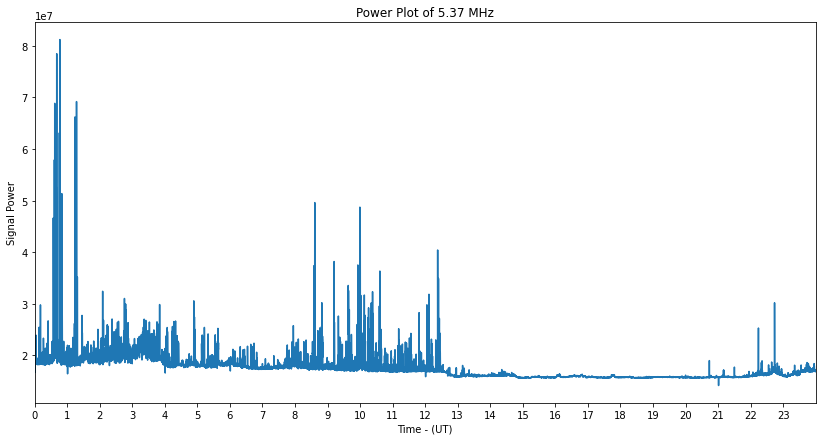

In [23]:
def plot_freq(time, freq, power, fig = True, axes = None):

    if fig: plt.figure(figsize=(14,7))
    ax = plt.gca() if axes is None else axes
    plt.plot(time,power)
    
    plt.xlim(0,24)
    plt.xticks(np.arange(0, 24, 1))

    plt.xlabel('Time - (UT)')
    plt.ylabel('Signal Power')
    plt.title('Power Plot of ' + str(freq[0]) + ' MHz')
    
    plt.show()
    
def plot_freq_ax(time, freq, power, f_str, ymin = 0, ymax = 1.2e8, fig = True, axes = None):

    if fig: plt.figure(figsize=(14,7))
    ax = plt.gca() if axes is None else axes
    
    
    ax.plot(time,power)
    ax.set_ylim(ymin = ymin, ymax = ymax)

    ax.set_xlabel('Time - (UT)',  fontsize=15)
    ax.set_ylabel('Signal Power', fontsize=15)
    ax.set_title(f_str, fontsize=12.1, fontweight="bold" )
    
plot_freq(f1_t, f1_f, f1_p)

We can now begin to find the actual frequency for each bin. Each bin has a specific bandwidth, we tabulate the information below:

In [13]:
def cent_f(i):
    return i*24414/(1e6)

cent_f(3) 

0.073242

In [24]:
def bandwidth(mp_index, t_freq, c_print = False, c_plot = True):
    print("Target Frequency:", t_freq)
    n_mp = mp_index
    MP = cent_f(n_mp); print("Mid point:", MP, '\n')
    xi = round(cent_f(n_mp -1), 6); #print("initial:", xi)
    xf = round(-xi + 2* MP, 6)
    
    if c_print:
        print("TEST: The upper limit", xf, "is equal to the next bin", cent_f(n_mp + 1))
        print('\n')
        print("For central frequency index: n_midpoint =",  n_mp + 1)
        print("The upper limit of", MP, "is", xf , "and the lower limit is", xi)
    
    bin_string = 'Bin: ' + str(MP)
    band_string = str(xi) + '-' + str(xf) 
    f_string =  bin_string + ' MHz, Band: ' + '(' + band_string + ')'
    if c_plot: return f_string
    else: return t_freq, MP, band_string

In [29]:
s_f1_tab = bandwidth(217 +3, 5.382    ,c_plot = False)
s_f2_tab = bandwidth(280 +4, 6.9285   ,c_plot = False)
s_f3_tab = bandwidth(327 +5, 8.0995   ,c_plot = False)
s_f4_tab = bandwidth(421 +6, 10.422   ,c_plot = False)
s_f5_tab = bandwidth(449 +6, 11.107   ,c_plot = False)
s_f6_tab = bandwidth(581 +8, 14.3704  ,c_plot = False)

Target Frequency: 5.382
Mid point: 5.37108 

Target Frequency: 6.9285
Mid point: 6.933576 

Target Frequency: 8.0995
Mid point: 8.105448 

Target Frequency: 10.422
Mid point: 10.424778 

Target Frequency: 11.107
Mid point: 11.10837 

Target Frequency: 14.3704
Mid point: 14.379846 



In [16]:
from IPython.display import HTML, display
import tabulate

In [26]:
table_prep = np.vstack((s_f1_tab, s_f2_tab, s_f3_tab, s_f4_tab, s_f5_tab, s_f6_tab))

display(HTML(tabulate.tabulate( table_prep,
                               headers = ['Target Frequency (MHz)', 'Bin Frequency (MHz)', 'Band Width (MHz)'],
                               tablefmt='html', numalign="center"))) 

Target Frequency (MHz),Bin Frequency (MHz),Band Width (MHz)
5.382,5.37108,5.346666-5.395494
6.9285,6.93358,6.909162-6.95799
8.0995,8.10545,8.081034-8.129862
10.422,10.4248,10.400364-10.449192
11.107,11.1084,11.083956-11.132784
14.3704,14.3798,14.355432-14.40426


In [27]:
from matplotlib import rc

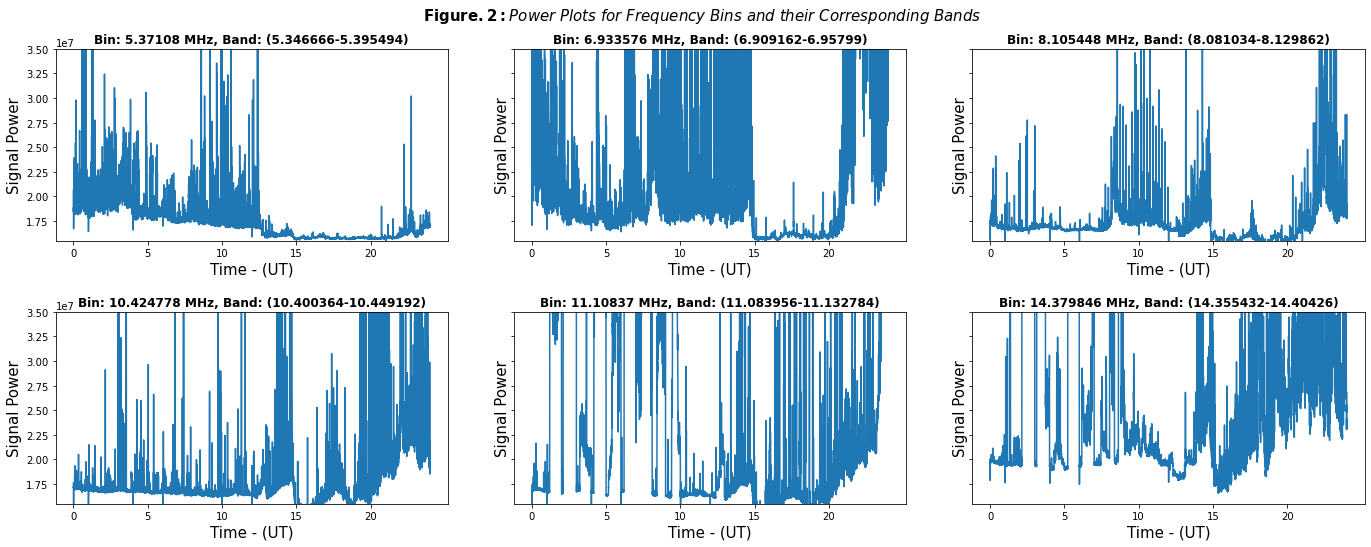

In [28]:
fig, axes = plt.subplots(2,3, figsize=(20,8), sharex = False, sharey = True)
fig.suptitle(r"$\bf {" + 'Figure. 2:' + "}$"+ 
             'Power Plots for Frequency Bins and their Corresponding Bands', fontsize=15, style='italic')
fig.tight_layout(pad=5.0)

plt.setp(axes, xticks=np.arange(0, 25, 5), xlabel = 'Time - (UT)', ylabel = 'Signal Power' )

ymin = 0.155e8; ymax = 0.35e8

plot_freq_ax(f1_t, f1_f, f1_p, s_f1, ymin, ymax, fig = False, axes=axes[0,0] )
plot_freq_ax(f2_t, f2_f, f2_p, s_f2, ymin, ymax, fig = False, axes=axes[0,1] )
plot_freq_ax(f3_t, f3_f, f3_p, s_f3, ymin, ymax, fig = False, axes=axes[0,2] )
plot_freq_ax(f4_t, f4_f, f4_p, s_f4, ymin, ymax, fig = False, axes=axes[1,0] )
plot_freq_ax(f5_t, f5_f, f5_p, s_f5, ymin, ymax, fig = False, axes=axes[1,1] )
plot_freq_ax(f6_t, f6_f, f6_p, s_f6, ymin, ymax, fig = False, axes=axes[1,2] )

Midway between 15 and 20 UT you can see the signals reappear at the same instant for the 5.93 and 8.11 MHz bands. This implies some interesting event occuring at this time and affecting these bands simutaneously.